In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/Users/infinity0106/Documents/Personal/jda_challenge


In [2]:
# importaciones para trabajar
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


In [3]:
# funcin para encontrar rows con valores vacios
def display_nan(df):
    print(df[df.isna().any(axis=1)].head())

def num_categories(df, column):
  values = df[column].unique()
  return len(values)



In [4]:
# importacion de datos
df = pd.read_csv("./server/input_data_train.csv")
df_pred = pd.read_csv("./server/input_data_pred.csv")
print(df.head())
# train
# location,product,date,sa_quantity,temp_mean,temp_max,temp_min,sunshine_quant,event,price
# sa_quantity is deleated
# pred
# location,product,date,temp_mean,temp_max,temp_min,sunshine_quant,event,price


   location  product        date  sa_quantity  temp_mean  temp_max  temp_min  \
0      1193        1  2011-12-31            5     10.635     11.19     10.08   
1      1193        1  2012-01-01            0      8.845     10.76      6.93   
2      1193        1  2012-01-02            2      5.510      7.24      3.78   
3      1193        1  2012-01-03            2      8.915     11.61      6.22   
4      1193        1  2012-01-04            0      7.380      8.87      5.89   

   sunshine_quant                         event  price  
0            56.0                New Year's Eve   1.48  
1           213.0                New Year's Day    NaN  
2           285.0       New Year's Day observed   1.50  
3           205.0  2nd January (substitute day)   1.50  
4           224.0                           NaN    NaN  


In [5]:
# fill NAN of  columns aplicable
df[["price"]] = df[["price"]].fillna(0)
df[["event"]] = df[["event"]].fillna("none")
df_pred[["price"]]=df_pred[["price"]].fillna(0)
df_pred[["event"]]=df_pred[["event"]].fillna("none")

print(df.head())


   location  product        date  sa_quantity  temp_mean  temp_max  temp_min  \
0      1193        1  2011-12-31            5     10.635     11.19     10.08   
1      1193        1  2012-01-01            0      8.845     10.76      6.93   
2      1193        1  2012-01-02            2      5.510      7.24      3.78   
3      1193        1  2012-01-03            2      8.915     11.61      6.22   
4      1193        1  2012-01-04            0      7.380      8.87      5.89   

   sunshine_quant                         event  price  
0            56.0                New Year's Eve   1.48  
1           213.0                New Year's Day   0.00  
2           285.0       New Year's Day observed   1.50  
3           205.0  2nd January (substitute day)   1.50  
4           224.0                          none   0.00  


In [6]:
# sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True)

df_pred['date'] = pd.to_datetime(df_pred['date'])
df_pred = df_pred.sort_values(by='date', ascending=True)



In [7]:
# remove last elements with nan in temparature and sunshine_quant
df[["sunshine_quant"]] = df[["sunshine_quant"]].fillna(0)
df_pred[["sunshine_quant"]] = df_pred[["sunshine_quant"]].fillna(0)
# df[["temp_mean"]] = df[["temp_mean"]].fillna(-100)


/Users/infinity0106/anaconda3/envs/ML/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


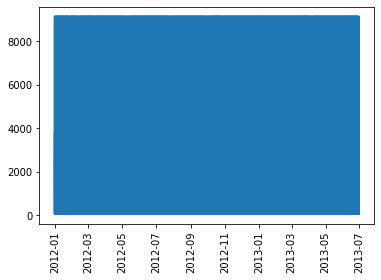

In [8]:
def plot_data(df, x_column, y_column):
    plt.plot(df[x_column], df[y_column])
    plt.xticks(rotation='vertical')
    
plt.rcParams['agg.path.chunksize'] = 10000
plot_data(df, 'date','location')

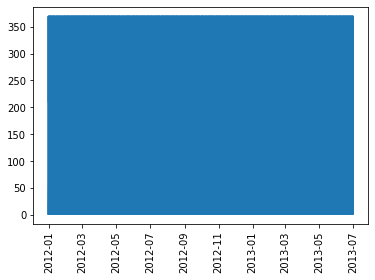

In [9]:
plot_data(df, 'date','product')

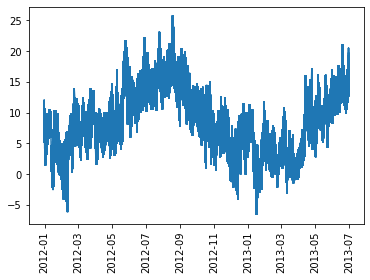

In [10]:
plot_data(df, 'date','temp_mean')

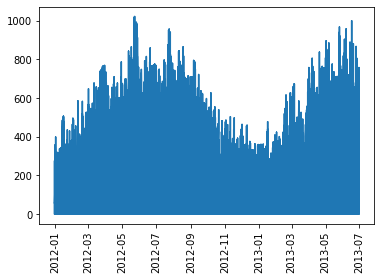

In [11]:
plot_data(df, 'date','sunshine_quant')

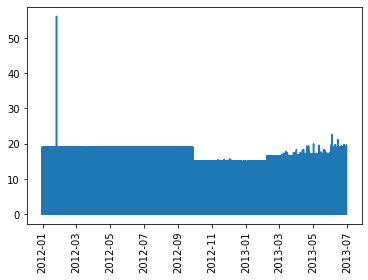

In [12]:
plot_data(df, 'date','price')

In [13]:
print(num_categories(df, "event"))
print(num_categories(df, "location"))
print(num_categories(df, "product"))


94
50
369


In [8]:
# load everything
with open('./server/columns.json') as f:
    config = json.load(f)

In [9]:
def validate_key(df, config):
  columns_types={
    "Numerical": [],
    "Categorical": [],
    "Date":[]
  }
  for key, value in config.items():
    try:
      if value != "Ignore":
        df[key]
        columns_types[value].append(key)
    except:
      print(f"key not existent {key}")
  return columns_types

info = validate_key(df, config)


key not existent test


In [10]:
def crate_categorical(df, df_pred, info):
  for key in info["Categorical"]:
    df[key] = df[key].fillna("none")
    dftmp=pd.get_dummies(pd.concat([df[key],df_pred[key]],keys=[0,1]), prefix=key, drop_first=True)
    dftmp,dftmp2 = dftmp.xs(0),dftmp.xs(1)
    df=pd.concat([df,dftmp], axis=1)
    df=df.drop([key], axis=1)
    df_pred=pd.concat([df_pred,dftmp2], axis=1)
    print(key)
  return df,df_pred

df,df_pred = crate_categorical(df,df_pred, info)

location
product
event


In [11]:
def normalize_numeric(df, df_pred, info):
  for key in info["Numerical"]:
    print(key, df[key].mean(), df[key].std())
    df[key] = (df[key]-df[key].mean())/df[key].std()
    df[key] = df[key].fillna(method='pad')
    print(key, df_pred[key].mean(), df_pred[key].std())
    df_pred[key] = (df_pred[key]-df_pred[key].mean())/df_pred[key].std()
    df_pred[key] = df_pred[key].fillna(method='pad')
    print(key)
  return df, df_pred

df_pred["sa_quantity"]=0
df, df_pred = normalize_numeric(df, df_pred, info)

sa_quantity 8.604585583447076 13.035948087840143
sa_quantity 0.0 0.0
sa_quantity
temp_mean 8.665875152068129 5.113954774452523
temp_mean 16.13281816123189 3.1640613478289183
temp_mean
sunshine_quant 348.4471897810219 191.2797378948464
sunshine_quant 367.7586956521739 303.0933810440322
sunshine_quant
price 2.51065932230138 2.026403638745706
price 2.623567280429941 2.096511576452252
price


In [ ]:
df.head()

In [18]:
df_pred.head()

,location,product,date,temp_mean,temp_max,temp_min,sunshine_quant,event,price,location_71,...,event_The Queen's Diamond Jubilee,event_Tisha B'Av,event_Trinity Sunday,event_Tu B'Shevat (Arbor Day),event_Valentine's Day,event_Whit Monday,event_Yom HaAtzmaut,event_Yom HaShoah,event_Yom Kippur,event_none
0,1193,1,2013-07-01,13.905,16.27,11.54,456.0,none,1.500000,0,...,0,0,0,0,0,0,0,0,0,1
1192504,5283,48,2013-07-01,12.625,16.29,8.96,641.0,none,1.800000,0,...,0,0,0,0,0,0,0,0,0,1
756792,3104,109,2013-07-01,14.600,18.03,11.17,650.0,none,3.285714,0,...,0,0,0,0,0,0,0,0,0,1
1605584,903,110,2013-07-01,16.870,19.75,13.99,704.0,none,1.485714,0,...,0,0,0,0,0,0,0,0,0,1
1192412,5283,47,2013-07-01,12.625,16.29,8.96,641.0,none,2.388889,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
df.isna().sum()

date                                        0
temp_mean                                   0
temp_max                                67896
temp_min                                67896
sunshine_quant                              0
price                                       0
location_71                                 0
location_97                                 0
location_136                                0
location_152                                0
location_165                                0
location_220                                0
location_246                                0
location_301                                0
location_327                                0
location_343                                0
location_369                                0
location_437                                0
location_576                                0
location_657                                0
location_709                                0
location_770                      

In [26]:
df = df.drop(["date", "temp_max", "temp_min"], axis=1)
df.shape

(10110600, 514)

In [27]:
df_pred = df_pred.drop(["date", "temp_max", "temp_min"], axis=1)
df_pred.shape

(1697400, 514)

In [47]:
df.to_pickle("preprocesed.pkl")

In [12]:
df_pred.to_pickle("preprocesed_pred.pkl")

In [5]:
df = pd.read_pickle("./preprocesed.pkl")

In [6]:
X = df.drop(["sa_quantity"],axis=1)
print(X.head())
Y = df["sa_quantity"]
print(Y.head())

         temp_mean  sunshine_quant     price  location_71  location_97  \
0         0.385049       -1.528898 -0.508615            0            0   
7337720        NaN       -1.821663 -0.745488            0            0   
7338268        NaN       -1.821663 -0.498745            0            0   
7338816        NaN       -1.821663  0.384241            0            0   
7339364        NaN       -1.821663 -1.238973            0            0   

         location_136  location_152  location_165  location_220  location_246  \
0                   0             0             0             0             0   
7337720             0             0             0             0             0   
7338268             0             0             0             0             0   
7338816             0             0             0             0             0   
7339364             0             0             0             0             0   

         ...  event_The Queen's Diamond Jubilee  event_Tisha B'Av  \

In [8]:
print(X.shape, Y.shape)

(10110600, 513) (10110600,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=69)

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))